# Customer Support Agent with LangChain


> ### **Objective**

Build a customer support agent for a music store which can do 3 things:

1. ***Authenticate*** the user and store their information
2. ***Query*** the store's db to make music recommendations, build playlists etc.
3. ***Summarize*** it's conversations, improving cost and performance over longer conversations

## 1. Authenticate

Getting customer info will look like this:

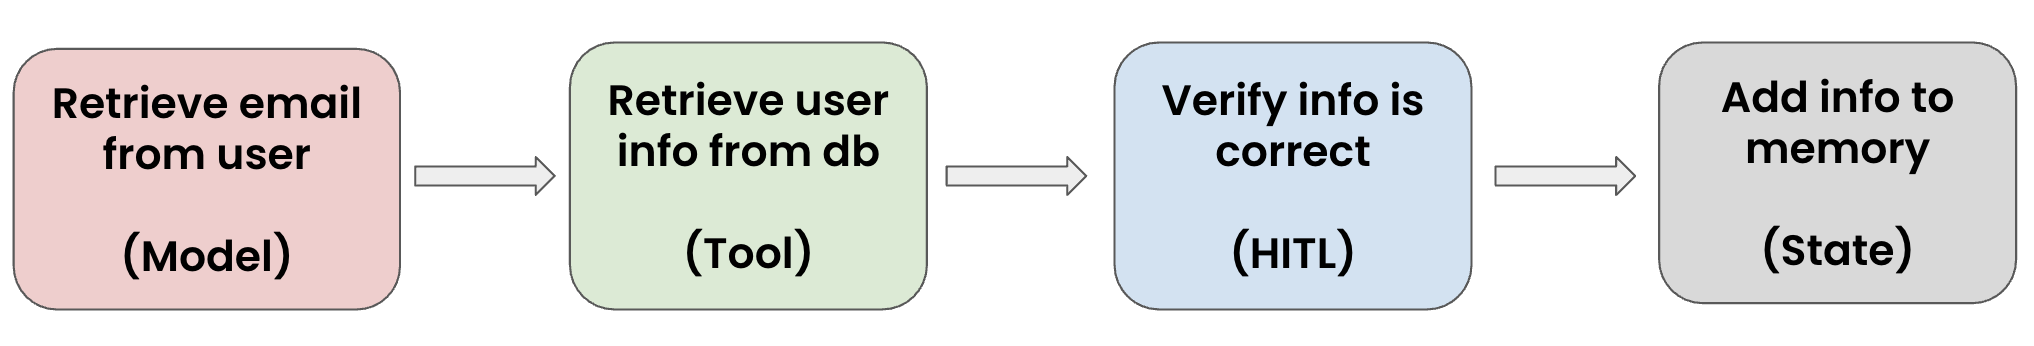

1.a Music Store Database

In [1]:
import sqlite3
import requests
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

# Create db
def get_engine_for_chinook_db():
    """Pull sql file, populate in-memory database, and create engine."""
    url = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql"
    response = requests.get(url)
    sql_script = response.text

    connection = sqlite3.connect(":memory:", check_same_thread=False)
    connection.executescript(sql_script)
    
    return create_engine(
        "sqlite://",
        creator=lambda: connection, 
        poolclass=StaticPool, 
        connect_args={"check_same_thread": False}, 
    )

engine = get_engine_for_chinook_db()
db = SQLDatabase(engine)

1.b Get Customer Info (Tool)

In [2]:
from langchain_core.tools import tool
from ast import literal_eval

@tool
def get_customer_info(email: str) -> dict:
    """Look up customer info given their email. ALWAYS make sure you have the email before invoking this.

    Args:
        email: str"""

    try:
        customer_info_as_string = db.run(f"SELECT * FROM Customer WHERE Email = '{email}';", include_columns = True)
        customer_info = literal_eval(customer_info_as_string[1:-1])
        customer_id = customer_info["CustomerId"]
        customer_name = customer_info["FirstName"]

        return {"customer_id": customer_id, "customer_name": customer_name}
    except Exception as e:
        
        return {"messages": e}

1.c Get Customer Email (Model)

In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage

# Build Model
model = ChatOpenAI(temperature=0, streaming=True, model="gpt-5-nano")

# create email retrieval prompt
email_msg = SystemMessage(content="You are a conversational and friendly assistant. " \
"Your only goal is to get the user to provide you their email address. " \
"Once you have received their email address, always retrieve their customer info" \
"Thank them, refer to them by their name and ask them how you can help. " \
"You do not know what you can help them with, just ask them how you can help. " \
"You may only speak in English unless directed otherwise.")

# Bind model to tool
customer_email_model = model.bind_tools([get_customer_info])

1.d Create System Memory (State)

In [4]:
from langgraph.graph import MessagesState

class State(MessagesState):

    customer_id: int
    customer_name: str

1.e Combine into 2 Nodes:

- Model Node (retrieves email and calls tool)
- Tool Node (performs info retrieval, checks with user (HITL), and updates State)

In [5]:
from langgraph.types import interrupt

# Create Nodes
def customer_email_node(state: State):

    return {"messages": [customer_email_model.invoke([email_msg] + state["messages"])]}

def get_info_node(state: State):
    """Performs the get customer info tool call."""

    # last message contains param tool_calls, a list of dicts
    tool_call = state["messages"][-1].tool_calls[0]

    # make tool call, draft tool message
    observation = get_customer_info.invoke(tool_call["args"])

    # check that we were able to retrieve info
    if "customer_name" in observation:
        # interrupt
        decision = interrupt({
            "question": "I've found the following account, is this you?",
            "account_details": observation
        })

        if decision == "yes":

            tool_message = {"role": "tool", "content" : observation, "tool_call_id": tool_call["id"]}

            # Add the final tool message to our messages
            return {'messages': tool_message, "customer_name": observation['customer_name'], 'customer_id': observation['customer_id']}

        else:

            tool_message = {"role": "tool", "content" : "Please ask the user to recheck the spelling of their email", "tool_call_id": tool_call["id"]}

            return {'messages': tool_message}
    
    # if we weren't then return the error to the customer and ask them to check spelling
    else:

        tool_message = {"role": "tool", "content" : "Error signing in! Please ask the user to recheck the spelling of their email!", "tool_call_id": tool_call["id"]}

        return {'messages': tool_message}

## 2. Query

We want our workflow to look like this:

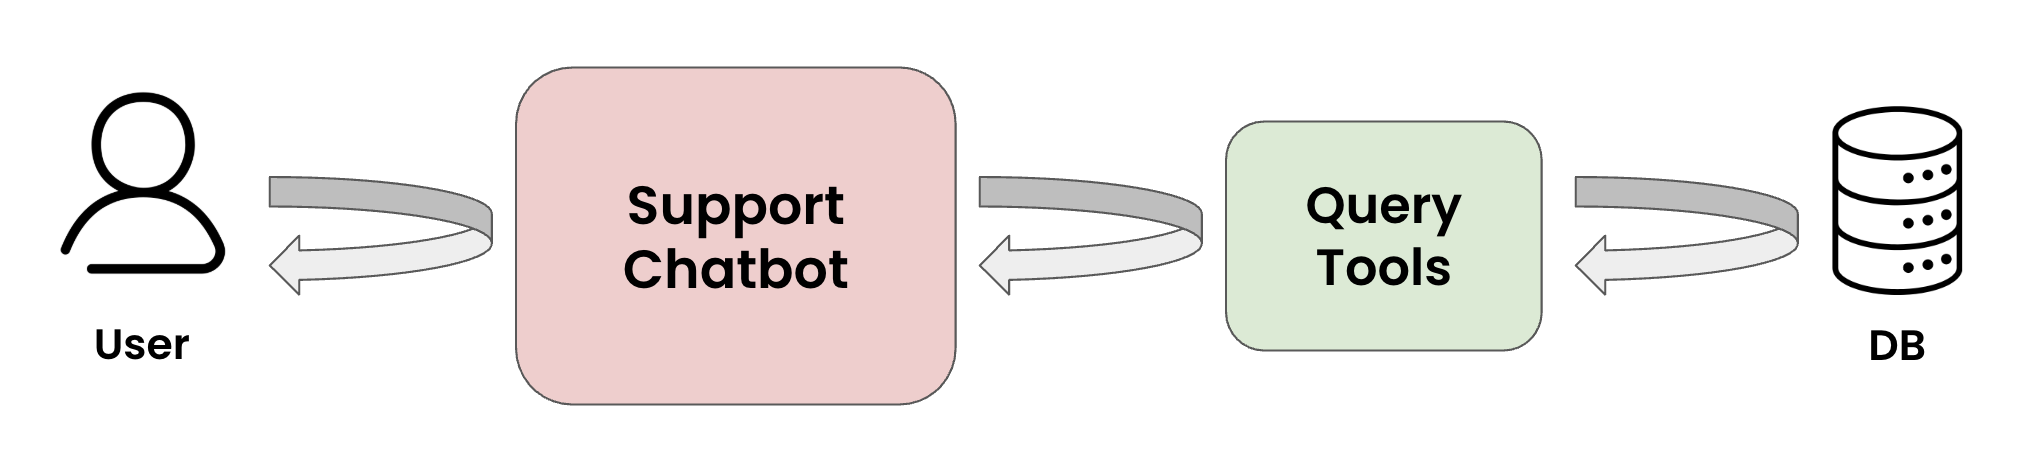

2.a SQL Query Tools

In [6]:
# tool 1 let's the model know keys are in a given table
@tool
def get_table_info(table_name: str) -> dict:
    """Run this call on a table within the database before running a sql query on that table.
    The table name HAS to be in the list db_table_names to be a valid table.

    Args:
        table_name: str"""

    try:
        table_info = db.get_table_info([table_name])
    except Exception as e:
        print(e)

    return {"table_name": table_name, "table_info": table_info}

# tool 2 formulates a sql query for a given table or tables
@tool
def make_sql_query(sql_query: str) -> dict:
    """Query the SQL database to retrieve information relevant to you or the customer.
    Before querying a table make sure to get_table_info.
    Some tables will contain a key for customer id.
    The customer id is defined in the state.
    You may not make a sql query for information that contains any other customer id.

    Args:
        sql_query: str"""
    sql_query_output = db.run(f"{sql_query}", include_columns = True)
    return {"sql_query_output": sql_query_output}

2.b Create Model

In [7]:
# Collect all tools
sql_tools = [make_sql_query, get_table_info]

# Bind tools to model
sql_model = model.bind_tools(sql_tools)

# Create prompt
sql_msg = SystemMessage(content="You are a conversational and friendly assistant for a physical-copy music store. " \
"You are equipped to help the customer do the following things, upon request:" \
" - look up information about their account and past purchases" \
" - browse our store's music catalogue" \
" - suggest music and build playlists for the customer" \
"If the customer asks you to do something outside this scope try to redirect them towards the topic of music" \
"Please use the customer's name and only speak English unless otherwise prompted")

2.c Create Nodes

In [8]:
from langgraph.prebuilt import ToolNode

def sql_model_node(state: State):

    # Get table names
    db_table_names = db.get_usable_table_names()

    # Inject state into the system prompt
    state_context = f"""
The current customer's ID is {state["customer_id"]}.
The current customer's name is {state['customer_name']}.
The valid database tables are: {db_table_names}.
Always use the customer's ID from state when making queries.
Do not ask the user for their ID.
"""
    contextual_sys_msg = SystemMessage(content=sql_msg.content + "\n\n" + state_context)


    return {"messages": [sql_model.invoke([contextual_sys_msg] + state["messages"])]}

# we can use the prebuilt package ToolNode for our sql query tools
# ToolNode only returns ToolMessage to message state so we couldn't use it in our auth flow

sql_tools_node = ToolNode(sql_tools)

## 3. Summarize

Once the model is ready to answer the user question we summarize the conversation to date and delete all previous messages

3.a Add summary to State

In [9]:
class State(MessagesState):

    customer_id: int
    customer_name: str
    summary: str

3.b Create summarizer node

In [10]:
from langchain_core.messages import HumanMessage, RemoveMessage

def summarizer_node(state: State):

    # First get the summary if it exists
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # If a summary already exists, add it to the prompt
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        # If no summary exists, just create a new one
        summary_message = "Create a summary of the conversation above:"

    # Pass our conversation messages plus the summary prompt to the model
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all messages and add our summary to the state
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"]]
    return {"summary": response.content, "messages": delete_messages}

## Combine





First we define the nodes of our system

In [11]:
from langgraph.graph import StateGraph, START, END

# Create graph
builder = StateGraph(State)

# Add nodes
builder.add_node("sql_model_node", sql_model_node)
builder.add_node("sql_tools", sql_tools_node)
builder.add_node("get_customer_email", customer_email_node)
builder.add_node("tools", get_info_node)
builder.add_node("summarizer_node", summarizer_node)

Now we define the "edges" of our system, the routes information takes between nodes

Some are pretty straightfoward i.e. a node can only route information to one other node

In [12]:
builder.add_edge("tools", "get_customer_email")
builder.add_edge("sql_tools", "sql_model_node")
builder.add_edge("summarizer_node", END)

Some are conditional i.e. a node could route information to more than one node depending on the State or the decision of the agent.

E.g. at the beginning when we choose to route the customer to the authentication agent or the query agent

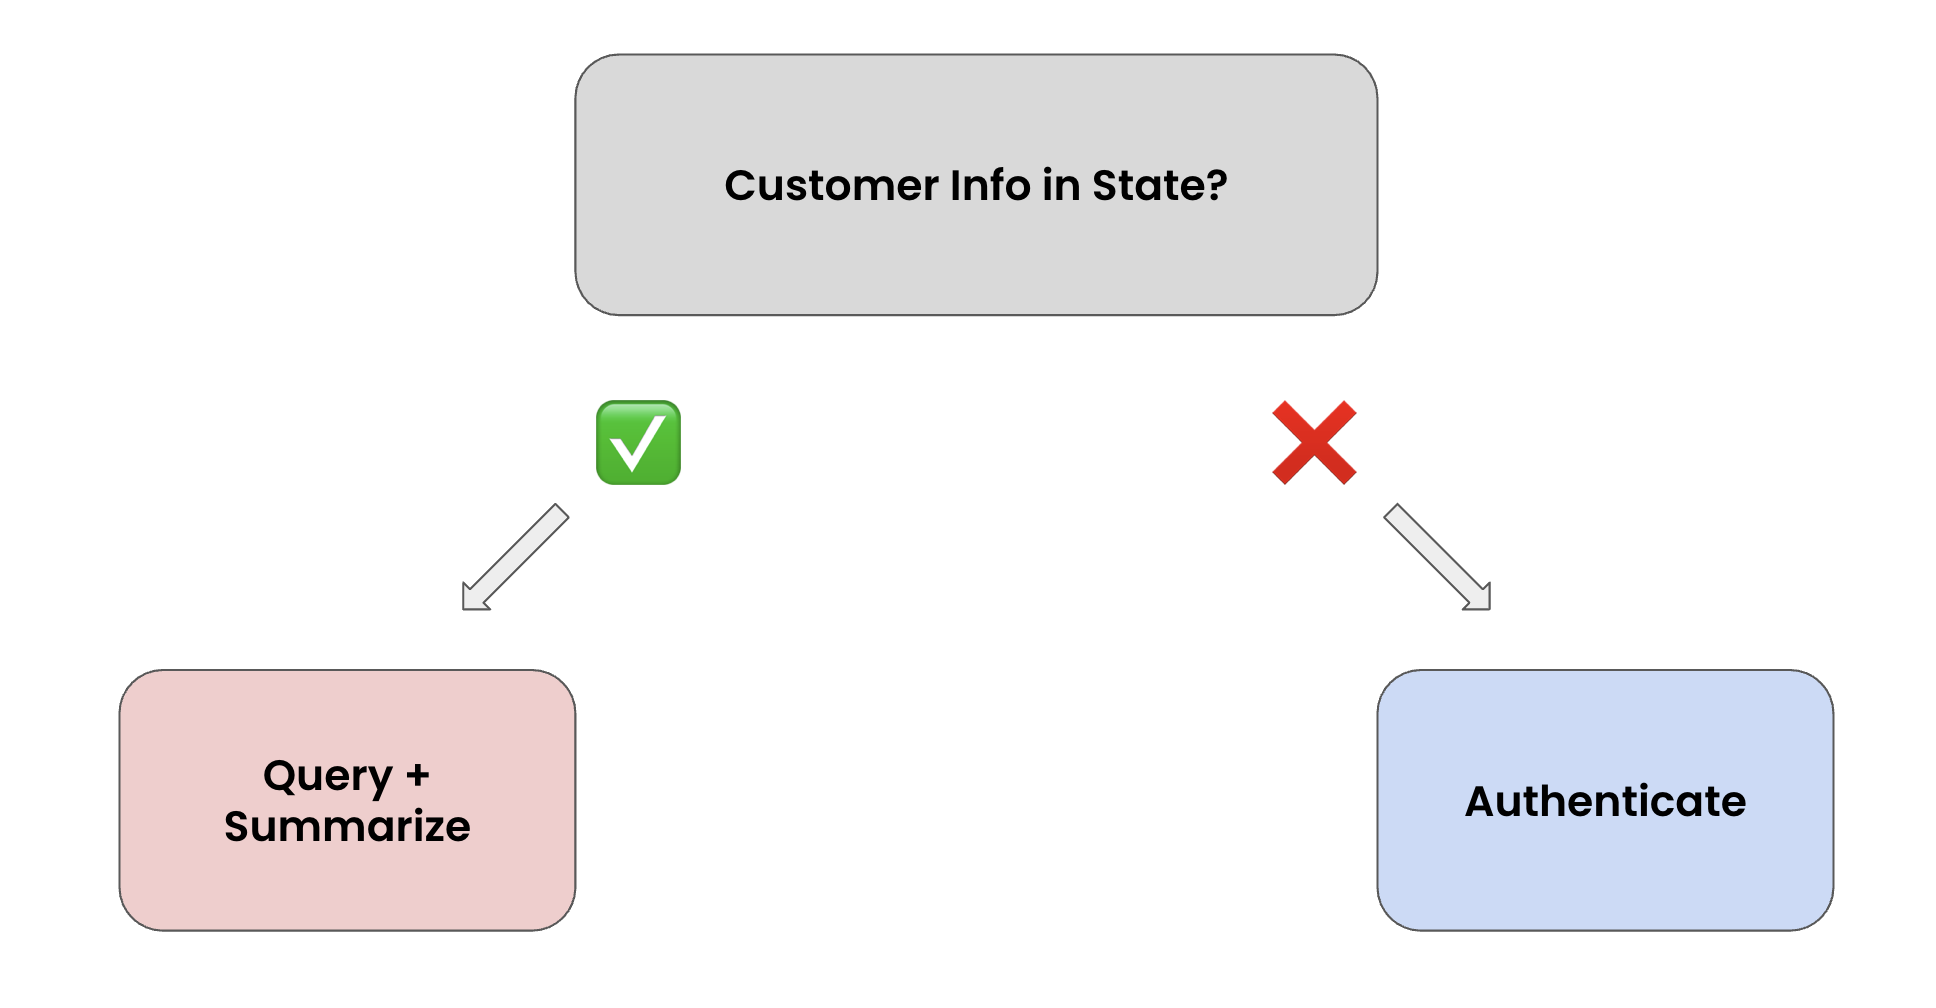

In [13]:
from langgraph.prebuilt import tools_condition
from typing import Literal

# Define conditional edges
def check_customer_info(state: State) -> Literal["get_customer_email", "sql_model_node"]:

    if "customer_id" not in state or "customer_name" not in state:
        return "get_customer_email"
    else:
        return "sql_model_node"

def sql_agent_condition(state: State) -> Literal["sql_tools", "summarizer_node"]:
    """Route to sql tool handler, or conversation summarizer if no tool is called."""

    # Get the last message
    message = state["messages"][-1]

    # Check if it's a Done tool call
    if message.tool_calls:
        return "sql_tools"
    else:
        return "summarizer_node"

# rather than define a custom condition we can use the prebuilt tools condition
# this only routes to "tools" or END so it can't be used for all conditional edges

customer_info_condition = tools_condition

builder.add_conditional_edges(START, check_customer_info)
builder.add_conditional_edges("get_customer_email", customer_info_condition)
builder.add_conditional_edges("sql_model_node", sql_agent_condition)

Compile together to form our system and view

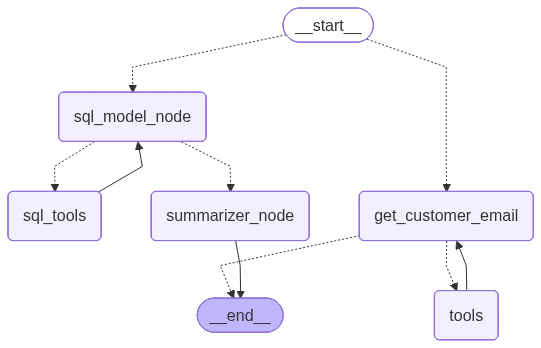

In [14]:
from IPython.display import Image, display

graph = builder.compile()

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Test

We can test our system here in this notebook or use LangGraph

Why choose LangGraph

- visualisation
- built in checkpointer
- LangSmith for debugging
- HITL & UX

It's extremely easy to set up all we need is to set up our "studio" directory

# Friction Log

- Appending customer info to state using ToolNode
- graph